## Importing necessary packages and data

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
from matplotlib import pyplot as plt

In [2]:
# Load the raw data from the quotes tab and clean selected quotes data
raw_data = pd.read_excel('data/treasury_quotes_2025-11-28.xlsx', sheet_name='quotes')
selected_data = pd.read_excel('data/treasury_quotes_2025-11-28.xlsx', sheet_name='selected quotes')

# Remove TIPS and eliminate any treasury without YTM or with negative YTM
data_full = raw_data[~raw_data['type'].str.contains('TIPS', case=False, na=False)].copy()
data_full = data_full[data_full['ytm'].notna() & (data_full['ytm'] > 0)].copy()

# Quote date
quote_date = pd.to_datetime('2025-11-28')

# Display first few rows of the selected data
selected_data.head()

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
0,208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
1,208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
2,208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
3,208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
4,208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588


## 1.1 Cashflow Matrix

In [3]:
# Create a grid of payment dates
payment_dates = sorted(selected_data['maturity date'].unique())

# Initialize the matrix with zeros
n_bonds = len(selected_data)
n_dates = len(payment_dates)
C = np.zeros((n_bonds, n_dates))

for i, row in selected_data.iterrows():
    # Semi-annual coupon
    coupon = row['cpn rate'] / 2
    
    # Find the index of this bond's maturity in our column list
    mat_idx = payment_dates.index(row['maturity date'])
    
    # Fill coupons backwards from maturity to the beginning
    C[i, :mat_idx+1] = coupon
    
    # Add face value to the maturity date
    C[i, mat_idx] += 100

# Convert the cashflow matrix to a pandas DataFrame
cashflows = pd.DataFrame(C, index=selected_data['KYTREASNO'], columns=payment_dates)

# Display the cashflow matrix
cashflows

,2026-05-31,2026-11-30,2027-05-31,2027-11-30,2028-05-31,2028-11-30,2029-05-31,2029-11-30,2030-05-31,2030-11-30,2031-05-31,2031-11-30,2032-05-31,2032-11-30,2033-05-15,2033-11-15,2034-05-15,2034-11-15,2035-05-15,2035-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,
208227,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208316,2.1250,102.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208399,1.9375,1.9375,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208484,1.6875,1.6875,1.6875,101.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208058,1.8125,1.8125,1.8125,1.8125,101.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208145,2.1875,2.1875,2.1875,2.1875,2.1875,102.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208229,2.2500,2.2500,2.2500,2.2500,2.2500,2.2500,102.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208318,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
208401,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,102.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0


## 1.2 Estimate Spot Discount Factors

In [4]:
# Create a vector of prices
price_vec = selected_data['price']

# Solve p = Cz
z = np.linalg.solve(cashflows, price_vec)
selected_data['discount_factor'] = z

# Display maturity date and discount factor
selected_data[['maturity date', 'discount_factor']]

,maturity date,discount_factor
0,2026-05-31,0.981343
1,2026-11-30,0.964472
2,2027-05-31,0.948551
3,2027-11-30,0.933088
4,2028-05-31,0.917225
5,2028-11-30,0.901050
6,2029-05-31,0.884954
7,2029-11-30,0.868448
8,2030-05-31,0.852545
9,2030-11-30,0.836465


## 1.3 Plotting discount factors and rates curve

The continuously compounded rate is defined as $r_{\text{cont}} = -\frac{\ln(Z)}{T}$.
The semiannually compounded rate is defined as $r_{\text{semi}} = 2 \left[ \left( \frac{1}{Z} \right)^{\frac{1}{2T}} - 1 \right]$.

In [5]:
# Using the existing 'ttm' column for time to maturity
time_grid = selected_data['ttm'].values
T = time_grid

# Calculate Rates from Discount Factors
z = selected_data['discount_factor'].values

# Semiannually compounded rate
r_semi = 2 * ((1/z)**(1/(2*T)) - 1)

# Continuously compounded rate
r_cont = -np.log(z) / T

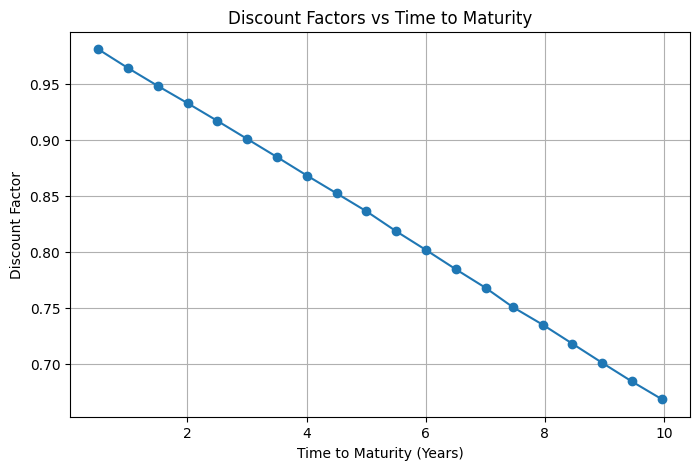

In [6]:
# Plot 1: Discount Factors
plt.figure(figsize=(8, 5))
plt.plot(T, z, marker='o', label='Discount Factors')
plt.title('Discount Factors vs Time to Maturity')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Discount Factor')
plt.grid(True)
plt.show()

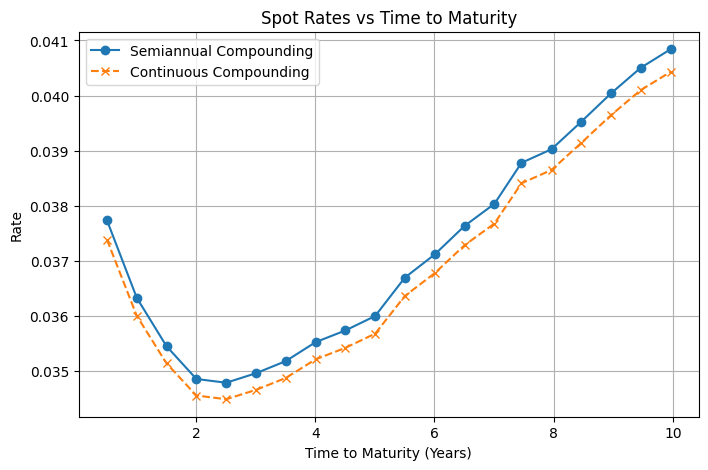

In [7]:
# Plot 2: Rates
plt.figure(figsize=(8, 5))
plt.plot(T, r_semi, marker='o', label='Semiannual Compounding')
plt.plot(T, r_cont, marker='x', linestyle='--', label='Continuous Compounding')
plt.title('Spot Rates vs Time to Maturity')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

## 1.4 Nelson-Siegel Curve Fitting

Nelson Siegel spot rate $r(t)$ is modeled as:
$$r(t) = \beta_0 + \beta_1 \left( \frac{1 - e^{-t/\tau}}{t/\tau} \right) + \beta_2 \left( \frac{1 - e^{-t/\tau}}{t/\tau} - e^{-t/\tau} \right)$$

In [8]:
# Define Nelson-Siegel spot rate function
def nelson_siegel_rate(t, theta):
    beta0, beta1, beta2, tau = theta
    if tau <= 0:
        return 1e10
    
    term1 = (1 - np.exp(-t/tau)) / (t/tau)
    term2 = term1 - np.exp(-t/tau)
    
    return beta0 + beta1 * term1 + beta2 * term2


# Function to calculate model prices based on NS parameters
def price_ns(theta, time_grid, cashflow_matrix):
    # Calculate rates for each time point in the grid
    r_ns = nelson_siegel_rate(time_grid, theta)
    
    # Convert to discount factors (continuous compounding)
    z_ns = np.exp(-r_ns * time_grid)
    
    # Calculate prices: P = C * z
    return cashflow_matrix @ z_ns


# Objective function: sum of squared errors
def objective(theta, time_grid, cashflow_matrix, market_prices):
    model_prices = price_ns(theta, time_grid, cashflow_matrix)
    return np.sum((model_prices - market_prices)**2)


# Initial guesses (beta0, beta1, beta2, tau)
initial_guess = [0.04, -0.02, 0.01, 1.0]

# Run optimization
res = optimize.minimize(
    fun=objective, 
    x0=initial_guess, 
    args=(time_grid, C, price_vec),
    method='L-BFGS-B',
    bounds=[(0, 1), (-1, 1), (-1, 1), (0.1, 10)]
)

theta_opt = res.x
ns_params_df = pd.DataFrame([theta_opt], columns=['beta0', 'beta1', 'beta2', 'tau'])
ns_params_df

,beta0,beta1,beta2,tau
0,0.051622,-0.012772,-0.033998,2.582985


To compare the Nelson-Siegel model (which uses continuous compounding) to market quotes (which use semiannual compounding), we use:
$$r_{\text{semi}} = 2 \left( e^{0.5 \cdot r_{\text{cont}}} - 1 \right)$$

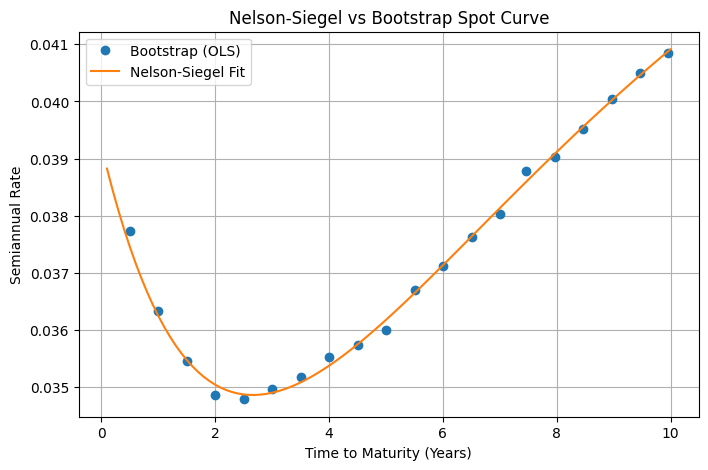

In [9]:
# Plot Nelson-Siegel vs Bootstrap
t_plot = np.linspace(0.1, 10, 100)
ns_rates_continuous = nelson_siegel_rate(t_plot, theta_opt)

# Convert continuous rate to semiannual compounding
ns_rates_semi = 2 * (np.exp(ns_rates_continuous * 0.5) - 1)

plt.figure(figsize=(8, 5))
plt.plot(selected_data['ttm'], r_semi, 'o', label='Bootstrap (OLS)')
plt.plot(t_plot, ns_rates_semi, label='Nelson-Siegel Fit')
plt.title('Nelson-Siegel vs Bootstrap Spot Curve')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannual Rate')
plt.legend()
plt.grid(True)
plt.show()

## 2.1 Map Cashflows

In [10]:
# Identify all unique payment dates in the dataset
pay_dates = pd.Series(data_full['maturity date'].unique()).sort_values()

# Construct the Cashflow Matrix Rows: Treasury Issues & Columns: Unique Payment Dates
C_full = pd.DataFrame(0.0, index=data_full['KYTREASNO'].unique(), columns=pay_dates)

for kytreasno in C_full.index:
    # Get the first row for this KYTREASNO (they should all be the same)
    row = data_full[data_full['KYTREASNO'] == kytreasno].iloc[0]
    maturity = row['maturity date']
    coupon = (row['cpn rate'] / 2)
    
    # Final payment (100 Face Value + Coupon)
    C_full.loc[kytreasno, maturity] = 100 + coupon
    
    # Map coupons backward every 6 months 
    curr_date = maturity - pd.DateOffset(months=6)
    while curr_date > quote_date:
        if curr_date not in C_full.columns:
            C_full[curr_date] = 0.0
        C_full.loc[kytreasno, curr_date] = coupon
        curr_date -= pd.DateOffset(months=6)

display(C_full.head())
print(f"Date with most cashflow across all issues: {C_full.sum(axis=0).idxmax()}")
print(f"Date with most issues paying: {(C_full > 0).sum(axis=0).idxmax()}")

,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2031-12-30,2032-03-30,2032-05-30,2036-08-15,2036-11-15,2036-05-15,2037-08-15,2037-11-15,2038-08-15,2038-11-15
208422,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Date with most cashflow across all issues: 2026-04-30 00:00:00
Date with most issues paying: 2026-02-15 00:00:00


## 2.2 OLS Estimation

In [11]:
# Create the filter to get subset C_hat
maturities = data_full['maturity date'].unique()
C_hat = C_full.loc[:, C_full.columns.isin(maturities)].copy()
display(C_hat.head(5), C_hat.tail(5))

,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208422,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.000,0.0000
208362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,102.3125,0.0000,0.000,0.0000
208405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000
208448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.375,0.0000
208490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125


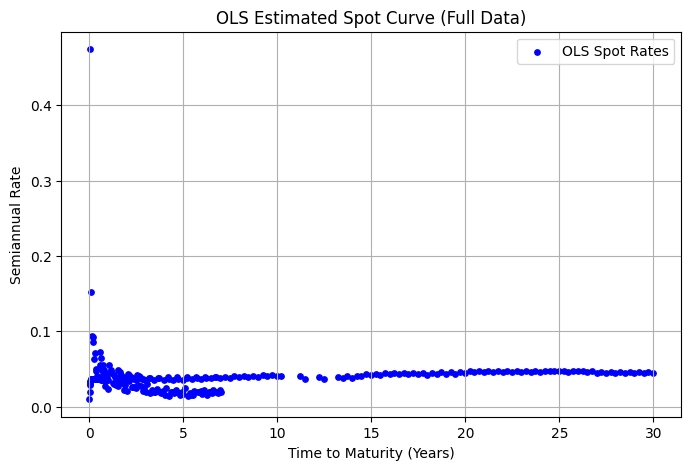

In [12]:
# Align prices with C_hat rows
prices_aligned = data_full.set_index('KYTREASNO').loc[C_hat.index, 'price']

# Solve for z_ols: p = C_hat * z
z_ols, resid, rank, s = np.linalg.lstsq(C_hat, prices_aligned, rcond=None)

# Calculate time to maturity for the columns of C_hat and semi-annual spot rates
ttm_hat = (C_hat.columns - quote_date).days / 365
r_ols_semi = 2 * ((1/z_ols)**(1/(2 * ttm_hat)) - 1)

plt.figure(figsize=(8, 5))
plt.scatter(ttm_hat, r_ols_semi, color='blue', s=15, label='OLS Spot Rates')
plt.title('OLS Estimated Spot Curve (Full Data)')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannual Rate')
plt.grid(True)
plt.legend()
plt.show()

## 2.3 Nelson-Siegel Curve-Fitting (Full Data)

In [13]:
# Initial guesses for the parameters: (beta0, beta1, beta2, tau)
initial_guess = [0.04, -0.02, 0.01, 1.0]

# Run optimization using C_hat and prices_aligned
res_hat = optimize.minimize(
    fun=objective, 
    x0=initial_guess, 
    args=(ttm_hat, C_hat, prices_aligned),
    method='L-BFGS-B',
    bounds=[(0, 1), (-1, 1), (-1, 1), (0.1, 10)]
)

# Extract optimized parameters
theta_opt_hat = res_hat.x
ns_params_hat_df = pd.DataFrame([theta_opt_hat], columns=['beta0', 'beta1', 'beta2', 'tau'])
display(ns_params_hat_df)

,beta0,beta1,beta2,tau
0,0.053783,0.018768,-0.12141,1.67223


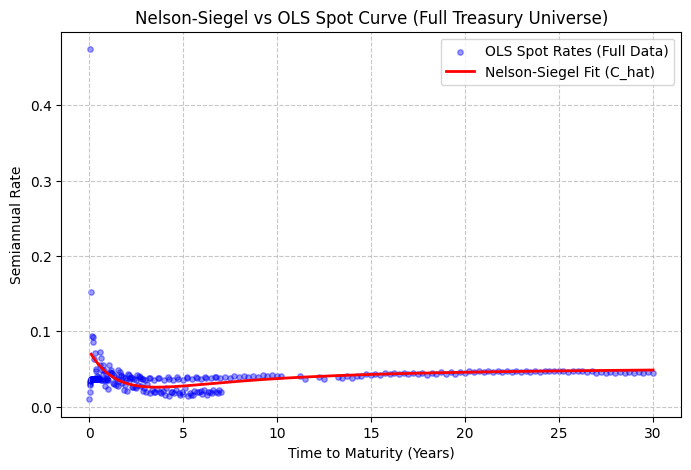

In [14]:
# Generate a smooth time grid for plotting
t_plot = np.linspace(0.1, 30, 300)
ns_rates_continuous_hat = nelson_siegel_rate(t_plot, theta_opt_hat)

# Convert continuous Nelson-Siegel rates to semiannual compounding for comparison
ns_rates_semi_hat = 2 * (np.exp(ns_rates_continuous_hat * 0.5) - 1)

plt.figure(figsize=(8, 5))

# Plot the OLS spot rates calculated in 2.2
plt.scatter(ttm_hat, r_ols_semi, color='blue', s=15, alpha=0.4, label='OLS Spot Rates (Full Data)')

# Plot the Nelson-Siegel fitted curve
plt.plot(t_plot, ns_rates_semi_hat, color='red', lw=2, label='Nelson-Siegel Fit (C_hat)')

plt.title('Nelson-Siegel vs OLS Spot Curve (Full Treasury Universe)')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannual Rate')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2.4 Weighted Least Squares
##### Weighting based on 'issue date' so more recently issued treasuries get higher weights


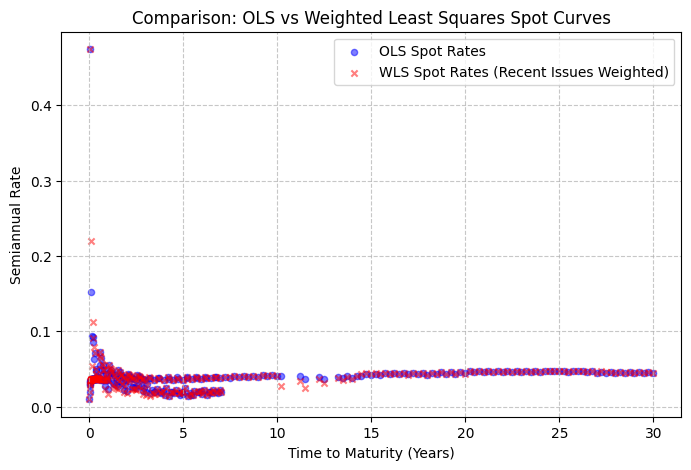

In [15]:
# Calculate days since issue for each treasury
data_full['days_since_issue'] = (quote_date - data_full['issue date']).dt.days

# Create weights based on exponential decay based on days since issue
half_life = 365
data_full['weight'] = np.exp(-np.log(2) * data_full['days_since_issue'] / half_life)

# Align weights with C_hat rows
weights_aligned = data_full.set_index('KYTREASNO').loc[C_hat.index, 'weight']

# Create the diagonal weight matrix
W = np.diag(weights_aligned)

# Convert C_hat and prices to numpy arrays
C_hat_array = C_hat.values
p_array = prices_aligned.values

# Calculate z_wls
z_wls = np.linalg.solve(
    C_hat_array.T @ W @ C_hat_array,
    C_hat_array.T @ W @ p_array
)

# Calculate semiannual spot rates for WLS
r_wls_semi = 2 * ((1/z_wls)**(1/(2 * ttm_hat)) - 1)

# Create comparison plot: OLS vs WLS
plt.figure(figsize=(8, 5))
plt.scatter(ttm_hat, r_ols_semi, color='blue', s=20, alpha=0.5, label='OLS Spot Rates', marker='o')
plt.scatter(ttm_hat, r_wls_semi, color='red', s=20, alpha=0.5, label='WLS Spot Rates (Recent Issues Weighted)', marker='x')
plt.title('Comparison: OLS vs Weighted Least Squares Spot Curves')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Semiannual Rate')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

##### The weighting scheme has some impact on the estimated spot curve, especially at the very front end of the curve and at 10-15 years. WLS places more weight on liquid, recently-issued 'on-the-run' bonds, resulting in slightly smoother curve that is more representative of current market conditions than OLS.